In [12]:
import yaml
import json
import tweepy
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
with open("twitter_api.yaml", "r") as yf:
    data = yaml.safe_load(yf)

In [3]:
## 認証処理
consumer_key = data['consumer_key']
consumer_secret = data['consumer_secret']
access_token_key = data['access_token_key']
access_token_secret = data['access_token_secret']
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)
api = tweepy.API(auth)

In [4]:
from requests_oauthlib import OAuth1Session

KEYS = {
    'consumer_key':consumer_key,
    'consumer_secret':consumer_secret,
    'access_token':access_token_key,
    'access_secret':access_token_secret,
}

twitter = OAuth1Session(KEYS['consumer_key'],KEYS['consumer_secret'],KEYS['access_token'],KEYS['access_secret'])

In [5]:
key_word = "機械学習"

In [6]:
url = "https://api.twitter.com/1.1/search/tweets.json"
params ={'q': key_word, 'count':'100','lang':'ja', 'result_type':'recent'}
res = twitter.get(url, params = params)

In [7]:
def getTwitterData(key_word, repeat):
    url = "https://api.twitter.com/1.1/search/tweets.json"
    params ={'q': key_word, 'count':'100','lang':'ja', 'result_type':'recent'}
    tweets = []
    mid = -1
    break_flag = 0
    
    for i in tqdm(range(repeat)):
        params['max_id'] = mid
        res = twitter.get(url, params = params)
        if res.status_code == 200:
            sub_tweets = json.loads(res.text)['statuses']
            limit = res.headers['x-rate-limit-remaining'] if 'x-rate-limit-remaining' in res.headers else 0
#            print("API残接続可能回数：%s" % len(limit))            
            tweet_ids = []
            for tweet in sub_tweets:
                tweet_ids.append(int(tweet['id']))
                tweets.append(tweet)
            if len(tweet_ids) > 0:
                min_tweet_id = min(tweet_ids)
                mid = min_tweet_id - 1
            else:
                break_flag = 1
                break;
                
            ## 終了判定
            if break_flag == 1:
                break;
                
        else:
            print("Failed: %d" % res.status_code)
            break_flag = 1
    
    print("ツイート取得数：%s" % len(tweets))
        
    return tweets

In [8]:
tweets = getTwitterData(key_word, 180)

 44%|████▍     | 80/180 [00:35<00:44,  2.24it/s]

ツイート取得数：7944


In [10]:
df_tweets = pd.DataFrame(tweets)
display(df_tweets.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7944 entries, 0 to 7943
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 7944 non-null   object 
 1   id                         7944 non-null   int64  
 2   id_str                     7944 non-null   object 
 3   text                       7944 non-null   object 
 4   truncated                  7944 non-null   bool   
 5   entities                   7944 non-null   object 
 6   metadata                   7944 non-null   object 
 7   source                     7944 non-null   object 
 8   in_reply_to_status_id      622 non-null    float64
 9   in_reply_to_status_id_str  622 non-null    object 
 10  in_reply_to_user_id        629 non-null    float64
 11  in_reply_to_user_id_str    629 non-null    object 
 12  in_reply_to_screen_name    629 non-null    object 
 13  user                       7944 non-null   objec

None

# 直近１週間のツイート数の推移

In [42]:
dateTimeIndex = pd.DatetimeIndex(df_tweets['created_at'])
df_tweets.index = dateTimeIndex

,created_at,id
0,2020-09-02 12:00:00+00:00,34
1,2020-09-02 13:00:00+00:00,85
2,2020-09-02 14:00:00+00:00,71
3,2020-09-02 15:00:00+00:00,48
4,2020-09-02 16:00:00+00:00,20
...,...,...
206,2020-09-11 02:00:00+00:00,41
207,2020-09-11 03:00:00+00:00,49
208,2020-09-11 04:00:00+00:00,40
209,2020-09-11 05:00:00+00:00,43


## 1時間ごと

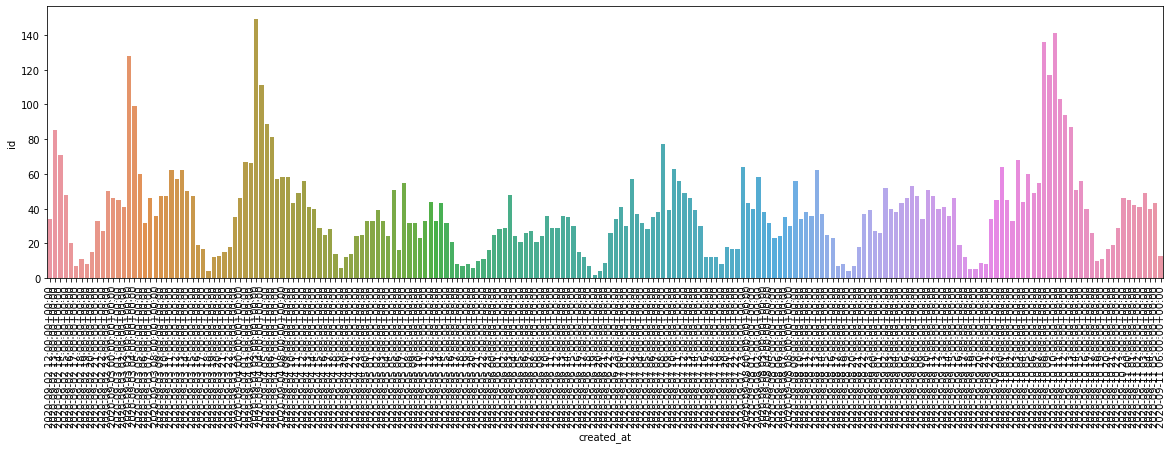

In [43]:
plt.figure(figsize=(20,5))
g = sns.barplot(x="created_at", y="id", data=df_tweets.resample("H")["id"].count().reset_index())
labels = g.get_xticklabels()
g.set_xticklabels(labels, rotation=90)
plt.show()

## 1日ごと

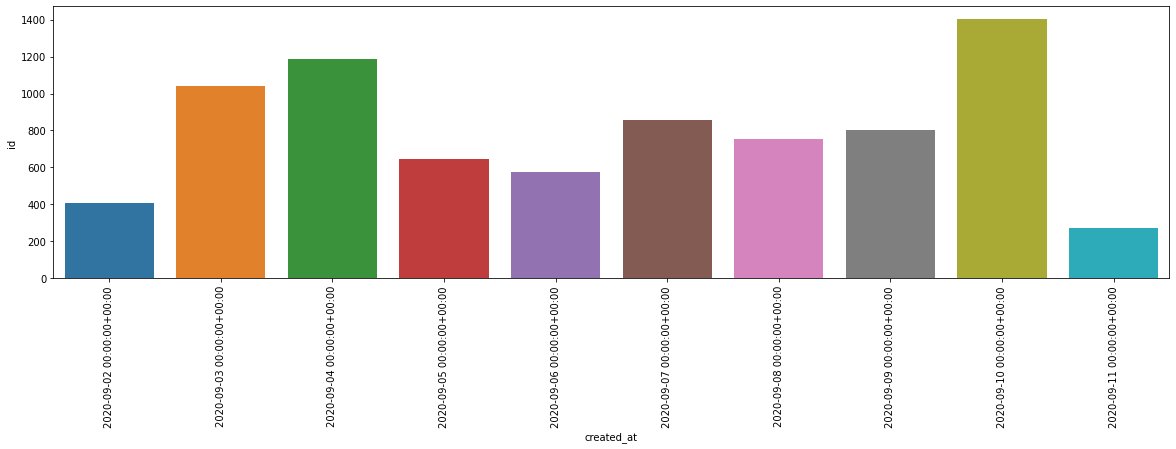

In [44]:
plt.figure(figsize=(20,5))
g = sns.barplot(x="created_at", y="id", data=df_tweets.resample("D")["id"].count().reset_index())
labels = g.get_xticklabels()
g.set_xticklabels(labels, rotation=90)
plt.show()

# ツイートしたユニークユーザ数

In [91]:
print(df_tweets['user'].shape[0])
df_user_unique = df_tweets['user'].apply(lambda x: x['screen_name']).nunique()
print(df_user_unique)

7944
5629
